# GS 102 Survey Data Analysis

### Professor Tiffany Page 

Now that you have collected some of your own survey data we are going to apply the analysis we learned in the data science modules earlier this semester to our own survey data! You will create bar charts using the demographic variables from our survey so that you can compare our sample with the larger UC Berkeley undergraduate population to determine the representativeness of our sample. You will create pivot tables with sets of variables and then create bar charts to visualize that data. You will then do some hypothesis testing. You will calculate p-values and determine whether there are any statistically significant associations. And, finally you will create word clouds for the open-ended survey questions.


*Estimated Time: 2 hours*

--------------------------------------------------------------------------------------------------------------------------------

# Table of Contents 

1. <a href = '#section0'>The Data</a>


2. <a href = '#section1'>Part I: Relationship between Demographic Factors and Presidential Choice</a>


3. <a href = '#section2'>Part II: Significance Tests for Categorical Variables</a>

    a. <a href = '#subsection2a'>Hypothesis Testing: The Basics</a>
    
    b. <a href = '#subsection2b'>The Chi-square Test: A Case Study</a>
    
    c. <a href = '#subsection2c'>Correlation vs. Causation</a>

6. <a href = '#section5'>Part V: Analyzing Text Responses</a>


7. <a href = '#section6'>Part VI: Bias in Surveys</a>


8. <a href = '#section7'>Bibliography</a>

# Topics Covered
 - Pivot Tables
 - Bar Charts 
 - Significance Tests and Chi-Square Goodness of Fit
 - Correlation vs. Causation
 - Bias in Survey Data

##### Dependencies: (Run the cell below before continuing)

In [1]:
from datascience import *
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
%matplotlib inline
sns.set()
import warnings
warnings.filterwarnings("ignore")

### Part I: Relationship between Demographic Factors and Presidential Choice <a id = 'section1'></a>

#### Exercise 1.1: Displaying Rows

Let's get an idea of the data we're working with. 

Run the next cell to load the data and display the first three rows. Then, run the next two cells to see the number of columns and the number of rows in the data set.

In [27]:
# load the data
data = Table().read_table('survey.csv')
# show the first 3 rows
data.show(3)

Q2,Q3,Q4,Q5,Q6,Q6_22_TEXT,Q7,Q8,Q8_6_TEXT,Q9,Q10,Q11,Q11_7_TEXT,Q12,Q12_4_TEXT,Q13,Q13_6_TEXT,Q14,Q14_8_TEXT,Q15
2,1,4,3,18,nan,climate change,1,nan,2,1,1,nan,1,nan,1,nan,5,nan,nan
3,3,4,2,18,nan,immigration,1,nan,3,3,2,nan,1,nan,7,nan,6,nan,Biden or Warren
2,3,4,2,18,nan,Climate change,1,nan,6,2,1,nan,1,nan,7,nan,6,nan,nan


In [3]:
# show the number of rows
data.num_rows

325

In [4]:
# show the number of columns
data.num_columns

20

#### Exercise 1.2: Convert Numerical Values to Readable Text

Run the next two cells to do some *data cleaning*. Here, we are going to take some actions to make the data easier for us and for the computer to use. First, we convert the numerical codes for each question's answers into readable text values. Then, we drop the rows with missing values.

In [28]:
# convert the values of some of the columns to readable text
for q in ["Q2", "Q3", "Q4"]:
    convert_num_to_text(data, q, ["0. None", "1. Once", "2. Twice", "3. Three or more times"])
convert_num_to_text(data, "Q5", ["1. Significantly", "2. A little", "3. No"])
convert_num_to_text(data, "Q6", ["Bennet", "Biden", "Booker", "Bullock", "Buttigieg", "Castro", "Delaney",
                                "Gabbard", "Messam", "Sanders", 'Harris', "O'Rourke", 'Ryan', 'Sestak', 
                                'Steyer', 'Trump', 'Walsh', 'Warren', 'Weld', 'Williamson', 'Yang', 
                                'Other', 'Undecided'])
convert_num_to_text(data, "Q8", ["Democrat", "Republican", "Libertarian", "Green", "Constitution", "Other", 
                                 "Independent", "I don't know"])
convert_num_to_text(data, "Q9", ["1. <$30,000", "2. $30,000-49,999", "3. $50,000-74,999", "4. $75,000-99,999",
                                "5. $100,000-149,999", "6. 150-000-$200,000", "7. More than $200,000", 
                                "8. Unknown", "9. Decline to state"])
convert_num_to_text(data, "Q10", ["Southern California", "Northern California", "Another US state/territory", 
                   "Another Country"])
convert_num_to_text(data, "Q11", ["Humanities", "Social Sciences", "Biological and Life Sciences", 
                                 "Physical Sciences", "Engineering", "Business", "Other"])
convert_num_to_text(data, "Q12", ["Woman", "Man", "Non-binary", "Self-described", "Decline to state"])
convert_num_to_text(data, "Q13", ["Christian", "Jewish", "Muslim", "Buddhist", "Hindu", "Other",
                                 "Do not identify with religion/faith", "Decline to state"])
convert_num_to_text(data, "Q14", 
                    ["African-American", "Native American", "Latinx", "Asian", "Middle Eastern", "White", "One or more", "Other", "Decline"])
# show the first three rows of the converted data
data.show(3)

Q2,Q3,Q4,Q5,Q6,Q6_22_TEXT,Q7,Q8,Q8_6_TEXT,Q9,Q10,Q11,Q11_7_TEXT,Q12,Q12_4_TEXT,Q13,Q13_6_TEXT,Q14,Q14_8_TEXT,Q15
1. Once,0. None,3. Three or more times,3. No,Warren,nan,climate change,Democrat,nan,"2. $30,000-49,999",Southern California,Humanities,nan,Woman,nan,Christian,nan,Middle Eastern,nan,nan
2. Twice,2. Twice,3. Three or more times,2. A little,Warren,nan,immigration,Democrat,nan,"3. $50,000-74,999",Another US state/territory,Social Sciences,nan,Woman,nan,Do not identify with religion/faith,nan,White,nan,Biden or Warren
1. Once,2. Twice,3. Three or more times,2. A little,Warren,nan,Climate change,Democrat,nan,"6. 150-000-$200,000",Northern California,Humanities,nan,Woman,nan,Do not identify with religion/faith,nan,White,nan,nan


In [29]:
# drop free text response question columns and rows with missing values
# this will allow our code to run smoothly when we analyze categorical data
data = encode_nans_table(data)
data = data.drop([c for c in data.column_labels if "TEXT" in c] + ["Q7", "Q15"])
data = Table.from_df(data.to_df().dropna(axis=0))
data.show(3)

Q2,Q3,Q4,Q5,Q6,Q8,Q9,Q10,Q11,Q12,Q13,Q14
1. Once,0. None,3. Three or more times,3. No,Warren,Democrat,"2. $30,000-49,999",Southern California,Humanities,Woman,Christian,Middle Eastern
2. Twice,2. Twice,3. Three or more times,2. A little,Warren,Democrat,"3. $50,000-74,999",Another US state/territory,Social Sciences,Woman,Do not identify with religion/faith,White
1. Once,2. Twice,3. Three or more times,2. A little,Warren,Democrat,"6. 150-000-$200,000",Northern California,Humanities,Woman,Do not identify with religion/faith,White


#### Exercise 1.3: Pivot Tables

Pivot tables are useful to compare two categorical variables. Here's an example:

In [54]:
# create a pivot table with questions 8 and 5
pivoted_data = data.pivot('Q8', 'Q5')
pivoted_data

Q5,Constitution,Democrat,Green,I don't know,Independent,Libertarian,Other,Republican
1. Significantly,1,7,1,2,5,0,1,2
2. A little,0,74,3,13,23,3,0,4
3. No,0,102,2,13,25,2,6,11


Let's understand what's happening here. Within the first column, we have the possibilities for respondent political party alignment. Along the rest of the columns, we have the possibilities for whether their political views changed since attending UC Berkeley.

Because there are different numbers of respondents for each party, we need to convert the counts in the pivot table to proportions to make fair comparisons.

The next cell uses the function `counts_to_proportions` to convert the pivot table into another pivot table with proportions. This function takes in a pivot table and returns a modified pivot table. 

In [55]:
# make a pivot table with the proportions
pivoted_proportions = counts_to_proportions(pivoted_data)
pivoted_proportions

Q5,Constitution,Democrat,Green,I don't know,Independent,Libertarian,Other,Republican
1. Significantly,0.0526316,0.368421,0.0526316,0.105263,0.263158,0,0.0526316,0.105263
2. A little,0,0.616667,0.025,0.108333,0.191667,0.025,0,0.0333333
3. No,0,0.63354,0.0124224,0.0807453,0.15528,0.0124224,0.0372671,0.068323


**Question:** Describe what you see in the table.

**Answer:** [Click on this cell and write your answer here]

**Question:** In the cell below, create pivot tables for other sets of variables and describe what the tables illustrate. You can copy and paste the code used to create the pivot tables above and change the variable names.

**Answer:** [Click on this cell and write your answer here]

In [ ]:
# replace the ... with the names of the two questions you want to compare
# remember to put the names inside quotation marks!
my_pivoted_data = data.pivot(..., ...)

# show your pivot table
my_pivot_data

In [ ]:
# run this cell to create the pivot table with the proportions instead of the counts
my_pivoted_proportions = counts_to_proportions(my_pivoted_data)
my_pivoted_proportions

**Question:** Now that you have a sense of the proportions of respondents in our sample that identified in each gender category, each racial category, each major, etc. compare the sample with summary statistics of the UCB undergraduate student population to determine the representativeness of our sample. Here are links that might help: https://opa.berkeley.edu/sites/default/files/ugprofile_2016-17_11april2018.pdf and https://diversity.berkeley.edu/reports-data/diversity-data-dashboard. Explain in what ways our sample is representative or not representative of the larger UCB undergraduate student population

**Answer:** [Click on this cell and write your answer here]

Awesome job! We're almost ready to start making inferences. The last step is to visualize our data. 

#### Exercise 1.4: Bar Charts

Bar charts help us visualize data and identify patterns and outliers. The next cell creates a bar chart of the data we examined earlier in pivot tables, comparing question 5 (political view changes) with question 8 (party alignment).

To make a bar plot, we can use the `barh` (horizontal bar plot) method on our proportions pivot table. The argument in the parentheses is the name of the second variable in the pivot table (the one that appears on top of the far-left column).

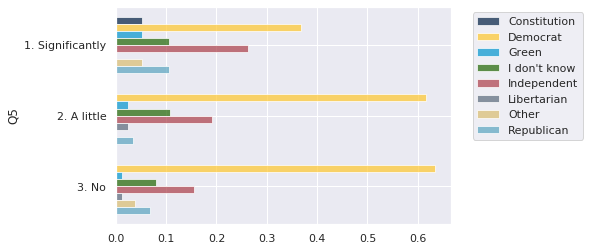

In [57]:
# create a bar plot
pivoted_proportions.barh("Q5")

**Question:** What does this bar chart tell us about the distribution of the variable?

**Answer:** [Click on this cell and write your answer here]

**Question:** Calculate what percentage of total respondents’ views changed significantly, a little and not at all.

**Answer:** [Click on this cell and write your answer here]

**Question:** In the cell below, create bar charts for the variables in the other pivot tables that you created.

**Answer:** [Click on this cell and write your answer here]

**TASK:** Use the `barh` method to visualize the proportions of the earlier pivot table you created. This function takes in one argument in the parentheses: the name of the second variable you chose to pivot (hint: it's the variable that appears at the top of the far left column in your pivot table).

In [ ]:
# replace the ... with the name of the second variable you chose
# remember to put the name inside quotation marks!
my_pivoted_proportions.barh(...)

**Question:** What patterns or differences do you see? Why do you think that may be the case?

**Answer:** [Click on this cell and write your answer here]

#### Exercise 1.5: Processing Pipeline

In data science, when you repeat a set of tasks to analyze a dataset, you are creating a *data processing pipeline*. 

Above, we compared two categorical variables by doing the following set of tasks:
1. creating a pivot table
2. turning the counts in the pivot table to proportions so we could make apples-to-apples comparisons
3. visualizing the proportions in a bar plot

It would be handy to quickly repeat these tasks for different combinations of variables. We can do that using Python. Run the next cell to make a function called `categorical_variable_relationship` which makes a function that will compare two categorical variables. The function takes three arguments: the Table with the data, and the names of the two variables to compare. It outputs a bar plot of the proportions of the two variables pivoted against one another.  

In [58]:
# run this cell to make the function
def categorical_variable_relationship(table, first, second):
    pivot = table.pivot(first, second)
    proportion_pivot = counts_to_proportions(pivot)
    proportion_pivot.barh(second, width=10, height=max(6, pivot.num_rows, pivot.num_columns))
    plt.legend(labels=pivot.column_labels[1:], title=first, loc=2, bbox_to_anchor=(1.05, 1))

As an example, in the next cell, the `categorical_variable_relationship` function is used to compare question 9 with question 2. Behind the scenes, the computer makes a pivot table and calculates the proportions, then shows us the bar graph.

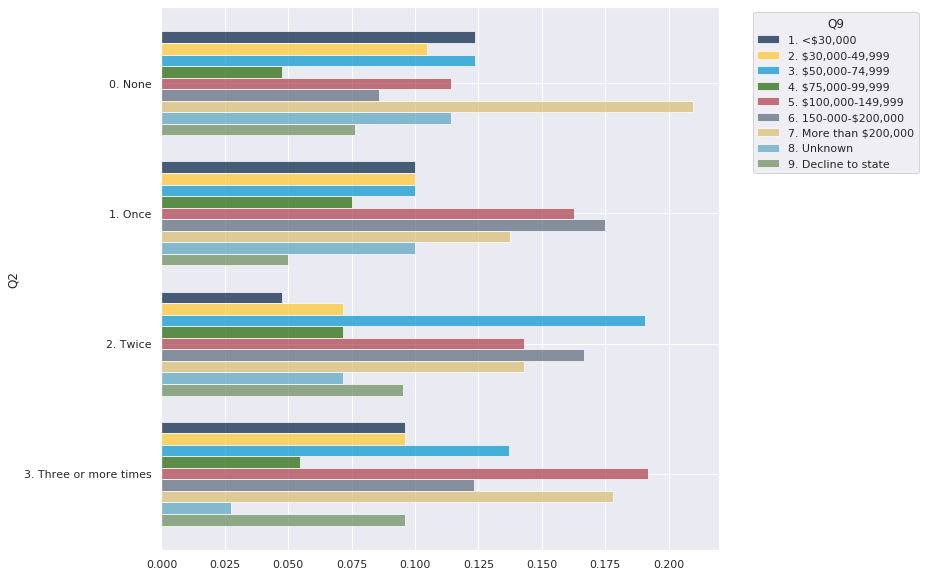

In [65]:
# visualize the relationship between Q9 and Q2 in a bar plot
categorical_variable_relationship(data, 'Q9', 'Q2')

**TASK**: Using the newly created `categorical_variable_relationship` function, plot a bar chart to find the relationship between two new categorical variables from the survey. Interpret the chart and write your findings below.

In [ ]:
# Replace the ... with the names of two categorical variables to compare
# Remember to put the names inside quotation marks!
categorical_variable_relationship(data, ..., ...)

**Answer:** [Click on this cell and write your answer here]

### Part II: Significance Tests for Categorical Variables <a id = 'section2'></a>

So far, we've created pivot tables between categorical variables and plotted bar charts to compare distributions. Based on these charts, we were able to come up with *qualitative differences* between variables. For example, we can say that, based on the bar chart of student majors, there isn't an *even/equal* distribution of majors within our sample. We know this because some majors had much higher counts than the others (*potentially overrepresented*). 






However, how do we know that these differences are not due to *random chance* alone? To answer this question, we turn to **hypothesis testing** for categorical variables. 

### Hypothesis Testing: The Basics <a id = 'subsection2a'></a>

Hypothesis tests are used when you observe some phenomena and want to know whether it happened by random chance alone or due to a specific cause. A *hypothesis* is an guess about the world, based on available evidence. We want to *test* between two different hypotheses:

- The **Null** Hypothesis: My observation has arisen due to **random chance alone**. 


- The **Alternative** Hypothesis: My observation has arisen due to a cause **other** than random chance alone. 

Ex: I flip a coin 100 times and get 99 heads. I want to conduct a hypothesis test to check whether the coin is fair or not. The null hypothesis is that I got 99 heads due to random chance alone (that is, the coin is fair). The alterative hypothesis is that I got 99 heads due to something other than random chance (which may indicate the coin is not fair, but doesn't exclude other non-random-chance reasons for the result).

### Step 1: Pivoting the Data

First, we use the `Table` method `.pivot` with the appropriate ordering of column names to generate the pivot table shown earlier. Run the cell to save this into a name called `party_by_race`. 

The independent variable, or the variable that we believe influences the other, is race/ethnicity. This variable should be presented along the columns of our pivot table. The dependent variable (political party) should be placed along the rows of the pivot table. 

In [37]:
# create a pivot table comparing party and race/ethnicity
party_by_race = data.pivot("Q14", "Q8")
party_by_race

Q8,African-American,Asian,Decline,Latinx,Middle Eastern,Native American,One or more,Other,White
Constitution,0,1,0,0,0,0,0,0,0
Democrat,2,63,1,28,6,3,18,2,60
Green,0,2,0,1,0,0,0,0,3
I don't know,1,16,0,5,1,0,0,1,4
Independent,2,23,0,6,4,0,5,0,13
Libertarian,0,3,0,1,0,0,1,0,0
Other,0,3,0,0,0,0,0,0,4
Republican,1,5,1,2,2,1,0,1,4


### Step 2: Adding Row and Column Totals

In order to calculate the expected counts under our null hypothesis of independence, we need to calculate row and column totals.

**Row totals** are horizontal sums added as the right-most column of the table. In this case, they would represent the total number of respondents from each racial/ethnic group in the dataset.

**Column Totals** are vertical sums added as the bottom row of the table. In our example, they represent the total number of respondents who align themselves with each political party option.

Run the next cell to create a table called `party_by_race_total` which adds a Row Total and Column Total to the `party_by_ethnicity` table. It uses the function `add_row_totals`, which takes in a pivot table and returns an updated version with the row totals. It also uses the function `add_column_totals`, which takes in a pivot table and returns an updated version with the column totals. 

In [38]:
# calculate the row and column totals and add them to the Table
party_by_race_totals = add_row_totals(party_by_race)
party_by_race_totals = add_column_totals(party_by_race_totals)
party_by_race_totals.show(11)

Q8,African-American,Asian,Decline,Latinx,Middle Eastern,Native American,One or more,Other,White,Row Total
Constitution,0,1,0,0,0,0,0,0,0,1
Democrat,2,63,1,28,6,3,18,2,60,183
Green,0,2,0,1,0,0,0,0,3,6
I don't know,1,16,0,5,1,0,0,1,4,28
Independent,2,23,0,6,4,0,5,0,13,53
Libertarian,0,3,0,1,0,0,1,0,0,5
Other,0,3,0,0,0,0,0,0,4,7
Republican,1,5,1,2,2,1,0,1,4,17
Column Total,6,116,2,43,13,4,24,4,88,300


The next cell uses a function called `get_p_value`. It takes a pivot table with row and column totals as its argument in the parentheses, and it outputs the p value.

In [39]:
# calculate the p value
get_p_value(party_by_race_totals)

0.7971052574819192

This last output is the **p-value**. This is a number which indicates the likelihood that your observations are consistent with the null hypothesis. In this case, our null hypothesis is that party choice and race/ethnicity are independent of each other. 

By convention, we say that:
- If the p-value is less than or equal to 0.05 then, we can reject the null hypothesis. Essentially, what we are saying here is that a 1 in 20 chance of observing our test statistic is too unlikely for the null hypothesis to be true.
- If the p-value is greater than 0.05, then we do not reject the null hypothesis.

Rejecting the null hypothesis means that we have evidence that supports the alternative hypothesis. In either case, notice that *we never accept* that a hypothesis is true; *rather, we simply reject or fail to reject it.* 

**Question:** Explain what this p-value means. Be specific based on the variables considered.

**Answer:** [Click on this cell and write your answer here]

### Another example
Now, let's repeat the process with two different questions from the survey: race/ethnicity and the frequency of election discussion.

In [43]:
# create the pivot table for the two questions
discussion_by_race = data.pivot("Q14", "Q2")
discussion_by_race

Q2,African-American,Asian,Decline,Latinx,Middle Eastern,Native American,One or more,Other,White
0. None,1,61,0,17,1,3,4,2,16
1. Once,0,29,0,7,5,1,8,0,30
2. Twice,2,12,2,4,2,0,6,2,12
3. Three or more times,3,14,0,15,5,0,6,0,30


In [44]:
# get the row totals for the pivot table
discussion_by_race_totals = add_row_totals(discussion_by_race)
discussion_by_race_totals = add_column_totals(discussion_by_race_totals)
discussion_by_race_totals

Q2,African-American,Asian,Decline,Latinx,Middle Eastern,Native American,One or more,Other,White,Row Total
0. None,1,61,0,17,1,3,4,2,16,105
1. Once,0,29,0,7,5,1,8,0,30,80
2. Twice,2,12,2,4,2,0,6,2,12,42
3. Three or more times,3,14,0,15,5,0,6,0,30,73
Column Total,6,116,2,43,13,4,24,4,88,300


In [45]:
# calculate the p-value
get_p_value(discussion_by_race_totals)

1.0697131632669455e-06

**Question:** Explain what this p-value means. Be specific based on the variables considered.

**Answer:** [Click on this cell and write your answer here]

**Task:** Repeat this with other combinations of variables to determine which relationships are statistically significant. Using the data table, run a hypothesis test. Write down the null hypothesis. Make the pivot table. Calculate the row totals, then calculate the p-value. Interpret the result. 

*Null Hypothesis:* [Click on this cell and write your answer here]

*Alternative Hypothesis:* [Click on this cell and write your answer here]

In [ ]:
# create the pivot table for the two questions
# TO DO: fill in the ... with the names of the questions you want to test
# make sure you put the question names in quotation marks!
my_pivot = data.pivot(..., ...)
my_pivot

In [ ]:
# get the row totals for the pivot table
my_totals = add_row_totals(my_pivot)
my_totals = add_column_totals(my_totals)
my_totals

In [ ]:
# calculate the p-value
get_p_value(my_totals)

**Question:** Should we reject or fail to reject the null hypothesis? Explain what it means to either reject or fail to reject the null hypothesis given the specific variables you are considering.

**Answer:** [Click on this cell and write your answer here]

### Discussion: Correlation vs. Causation <a id = 'subsection2c'></a>

In any class involving statistics, you may have heard the adage, *"Correlation doesn't imply causation."* 

Let's clarify what that means and why it's so important. *Correlation* is the inter-relation in trends of two variables (ex: gender and political party). Whereas, *Causation* is an explicit statement that a change in one variable directly incites a change in the other variable (ex: smoking and respiratory illness). 


Let's look at some concrete examples of why correlation isn't the same as causation. For instance, there is a 95.8% correlation between the per capita consumption of mozzarella cheese and the number of Civil Engineering doctorates awarded in the US. Clearly, these are two completely unrelated events that aren't linked to one another. As such, we wouldn't use this correlation as evidence of causality between these variables. 

For more "Spurious Correlations", check out this link: https://www.tylervigen.com/spurious-correlations


During hypothesis testing, we were able to find that the relationship between certain variables deviated significantly from the null hypothesis. Does this mean that one variable *causes* the other? No. To establish that relationship, we must gather more evidence.

Typically, to establish a causal relationship between variables, you must perform a randomized controlled experiment. If you're interested in this topic, you can check out this link for more information: https://www.statisticssolutions.com/establishing-cause-and-effect/



### Part V: Analyzing Text Responses <a id = 'section5'></a>

So far, we've been dealing with survey data in the form of multiple choice questions or rankings. However, sometimes in a survey, you want to ask responders to enter text or multple responses for their answer. One example of this is the column **'Q15'** which is about the responder's final thoughts.

#### Exercise 5.1: Word Clouds

To deal with data in the form of text, we can use word clouds. These data visualizations are commonly used when you want to display the most frequently occuring words in a piece of text. They work by counting the number of occurences of each word in a set of text, and then display each word proportionally to its frequency. Thus, more frequent words look bigger and vice versa. 

Here's an example using question 15. When we loaded the data the first time, we quickly dropped the columns with free text data so we could focus on analyzing the categorical data. Here, we're going to load only the questions that have free response text answers. Run the next cell to load the data.

In [52]:
# load the text response data
text_data = Table.read_table("survey_text_data.csv")
text_data

Q6_22_TEXT,Q8_6_TEXT,Q11_7_TEXT,Q12_4_TEXT,Q13_6_TEXT,Q14_8_TEXT,Q7,Q15
nan,nan,nan,nan,nan,nan,climate change,nan
nan,nan,nan,nan,nan,nan,immigration,Biden or Warren
nan,nan,nan,nan,nan,nan,Climate change,nan
nan,nan,nan,nan,Catholic,nan,Immigration,No
nan,nan,nan,nan,nan,nan,Environment Preservation,nan
nan,nan,nan,nan,nan,nan,Positive Freedom,nan
nan,nan,nan,nan,nan,nan,Climate change,nan
nan,nan,nan,nan,nan,nan,Foreign Policy,nan
nan,nan,nan,nan,nan,nan,Universal healthcare,None
nan,nan,nan,nan,nan,nan,Foreign Affairs,nan


We can then use the `create_word_cloud` function to make a word cloud. The first argument in the parentheses is the table of data, the second is the name of the column we want to visualize.

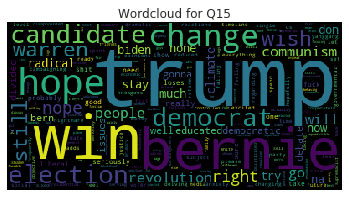

In [53]:
# create a word cloud for question 15
create_wordcloud(text_data, 'Q15')

**Question:** Please describe what you conclude from the word cloud along with any qualifications that you have about your conclusions. 

**Answer:** [Click on this cell and write your answer here]

**TASK:** Create a wordcloud for the column **"Q7"** using the `create_wordcloud` function, which takes in a table name and a column name containing text data. Write your observations below. 

In [ ]:
# make a word cloud by replacing the ... with the name of the correct column
# make sure to put the column name in quotation marks!
create_wordcloud(text_data, ...)

**Question:** Please describe what you conclude from the word cloud along with any qualifications that you have about your conclusions. 

**Answer**: [Click on this cell and write your answer here]

### Part VI: Bias in Surveys <a id = 'section6'></a>

The goal of a survey is to provide information about a large population from a limited sample. In this notebook, we've gone quite in depth in how to analyze different variables present in a survey. However, we've operated under the assumption that our survey data was representative of the UC Berkeley student population. However, in the real world, data collection is messy and difficult. Thus, we must be aware of sources of bias that may be present in our data. Here are a few common sources of bias in survey data:

- **Undercoverage bias**: Certain groups of the population are left out of the sample, leading to an *undercoverage* of responses in the sample


- **Nonresponse bias**: If the survey is optional, then certain respondents may not complete it. This may lead to skewed data. 


- **Self-selection bias**: If sample members volunteer themselves to take the survey, it may be the case that they are passionate about the issues asked about. This usually leads to an over-representation of individuals with strong opinions in the survey.


**TASK:** Given these sources of bias, do you see any problems with the methodology of our survey (including survey design, question wording, and distribution)? If you see any problems, what changes to our survey project would you make to fix them?


**Answer:** [Click on this cell and write your answer here]

--------------------------------------------------------------------------------------------------------------------------------

## Bibliography <a id = 'section7'></a>

• Caitlin Light - Adapted Chi-square case study. https://www.ling.upenn.edu/~clight/chisquared.htm

• Tyler Vigen - Incorporated example of "spurious" correlation. https://www.tylervigen.com/spurious-correlations

• Statistics Solutions - Referenced section on experimental design. https://www.statisticssolutions.com/establishing-cause-and-effect/

• Stat Trek - Adapted material on sources of survey bias. https://stattrek.com/survey-research/survey-bias.aspx

___
### Getting extra help

Interested in more help with learning Python or computational survey analysis? Check out  [Data Peer Consulting](https://data.berkeley.edu/education/data-peer-consulting) in Moffitt library for drop-in, one-on-one questions. For additional workshops designed for people new to computational analysis, take a look at the workshops at [The Dlab](https://dlab.berkeley.edu) (free for Berkeley students!). 

Good luck!

------------------------------------------------------------------------------------------------------------------------

### Feedback:
Please let us know your thoughts on this notebook!

Fill out the survey at this link: https://docs.google.com/forms/d/e/1FAIpQLSfahkYSKqlEEfC6WMKlaqeIxRVj0r7T4N5lgBf9bRVwRG58wQ/viewform

#### Note to Students: 
If you would like to use the utility provided by the Data Science Education Program team, simply copy the `utils.py` script to the folder where you are creating your analysis notebook. Good luck!

------------------------------------------------------------------------------------------------------------------------
Notebook developed by: Ritvik Iyer, Jiaqi (Arianna) Guo, Monica Wilkinson

Data Science Modules: http://data.berkeley.edu/education/modules